# Predicting Stock Prices and Making $$$ Using the ARMA Model

https://www.youtube.com/watch?v=Vyr5dthe-2s

In [1]:
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

#in practice do not supress these warnings, they carry important information about the status of your model
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Simulate Buying and Selling Stock Using ARMA(p,q)

In [2]:
def run_simulation(returns, prices, amt, order, thresh, start_idx=14, fit_window=None, verbose=False, plot=False):
    if type(order) == float:
        thresh = None
        
    curr_holding = False
    events_list = []
    init_amt = amt
    trade_pred = None
    dates_preds = []
    preds = []
    cum_dates = []
    cum_amts = []

    if fit_window is not None:
        start_idx = fit_window - 1  # Adjust start to ensure initial fit uses exactly fit_window points

    # go through dates
    for date, r in tqdm(returns.iloc[start_idx:].items(), total=len(returns.iloc[start_idx:])):
        # get data til just before current date? No, [:date] includes date for forecast next
        full_data = returns[:date]
        curr_data = full_data if fit_window is None else full_data.tail(fit_window)
        
        pred = None  # Default if not ARIMA
        if type(order) == tuple:
            try:
                model = ARIMA(curr_data.values, order=order)
                model_fit = model.fit()
                pred = model_fit.forecast(steps=1)[0]

            except:
                pred = thresh - 1
            
            dates_preds.append(date)
            preds.append(pred)

        # if you're currently holding the stock, sell it
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding = False
            ret = (sell_price - buy_price) / buy_price
            amt *= (1 + ret)
            events_list.append(('s', date, ret))
            
            if verbose:
                print('Sold at $%s' % sell_price)
                if type(order) == tuple and trade_pred is not None:  # Fixed bug
                    print('Predicted Return: %s' % round(trade_pred, 4))
                print('Actual Return: %s' % (round(ret, 4)))
                print('=======================================')

        # if you predict a high enough return and not holding, buy stock
        if (not curr_holding) and \
           ((type(order) == float and np.random.random() < order) 
            or (type(order) == tuple and pred > thresh)
            or (order == 'last' and curr_data.iloc[-1] > 0)):
            
            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if type(order) == tuple:  # Save for next sell print
                trade_pred = pred
            if verbose:
                print('Bought at $%s' % buy_price)
        
        # Record cumulative amount after each date's actions
        cum_dates.append(date)
        cum_amts.append(amt)
                
    if verbose:
        print('Total Amount: $%s' % round(amt, 2))
        
    # graph
    if plot:
        has_arima = type(order) == tuple and preds
        num_plots = 1  # Price plot
        if has_arima:
            num_plots += 1  # ARIMA returns plot
        num_plots += 1  # Cumulative P&L plot
        
        fig = plt.figure(figsize=(10, 4 * num_plots))
        
        plot_idx = 1
        ax1 = fig.add_subplot(num_plots, 1, plot_idx)
        ax1.plot(prices.iloc[start_idx:])

        y_lims = (int(prices.min() * 0.95), int(prices.max() * 1.05))
        shaded_y_lims = int(prices.min() * 0.5), int(prices.max() * 1.5)

        for idx, event in enumerate(events_list):
            ax1.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                ax1.fill_betweenx(range(*shaded_y_lims), 
                                  event[1], events_list[idx - 1][1], color=color, alpha=0.1)

        tot_return = round(100 * (amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        ax1.set_title("%s Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s" % (tickerSymbol, thresh, round(amt, 2), tot_return), fontsize=20)
        ax1.set_ylim(*y_lims)
        
        if has_arima:
            plot_idx += 1
            ax2 = fig.add_subplot(num_plots, 1, plot_idx)
            # Plot aligned predicted and actual next-day returns as overlapping bars
            plot_dates = dates_preds[1:]
            predicted_returns = preds[:-1]
            actual_returns = returns[plot_dates]  # Slice actual returns to match
            ax2.bar(plot_dates, actual_returns, alpha=0.5, color='blue', label='Actual Next-Day Returns')
            ax2.bar(plot_dates, predicted_returns, alpha=0.5, color='red', label='Predicted Next-Day Returns')
            ax2.set_title('Actual and Predicted Next-Day Returns', fontsize=14)
            ax2.legend()
        
        # Cumulative Profit and Loss plot
        plot_idx += 1
        pnl_ax = fig.add_subplot(num_plots, 1, plot_idx)
        cumulative_profit = [a - init_amt for a in cum_amts]
        pnl_ax.plot(cum_dates, cumulative_profit, color='purple')
        pnl_ax.set_title('Cumulative Profit and Loss', fontsize=14)
        pnl_ax.set_xlabel('Date')
        pnl_ax.set_ylabel('Profit/Loss ($)')
        pnl_ax.axhline(0, color='black', linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        plt.show()
    
    return amt

In [3]:
from statsmodels.tsa.stattools import adfuller
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] <= 0.05:
        print("✅ The series is likely stationary.")
    else:
        print("❌ The series is likely non-stationary.")

# Read Data

In [4]:
tickerSymbol = 'TSLA'
data = yf.Ticker(tickerSymbol)

# prices = data.history(start='2021-01-01', end='2021-04-01').Close

prices = data.history(start='2024-01-01', end='2025-09-11').Close
returns = prices.pct_change().dropna()
print(returns.shape)

(423,)


Text(0, 0.5, 'Prices')

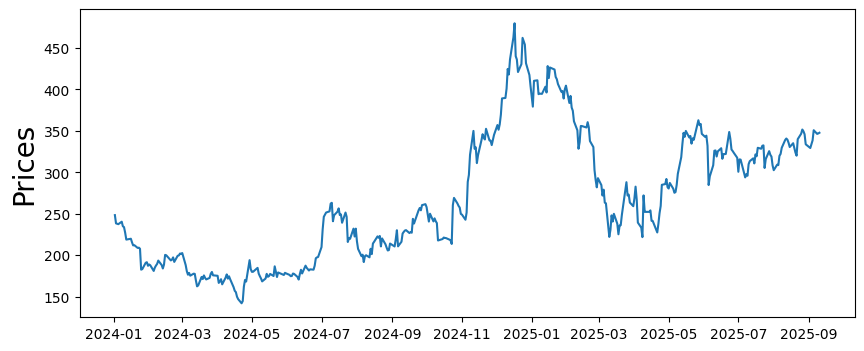

In [5]:
returns = prices.pct_change().dropna()

plt.figure(figsize=(10,4))
plt.plot(prices)
plt.ylabel('Prices', fontsize=20)

In [6]:
perform_adf_test(prices)

ADF Statistic: -1.329418
p-value: 0.615608
❌ The series is likely non-stationary.


Text(0, 0.5, 'Return')

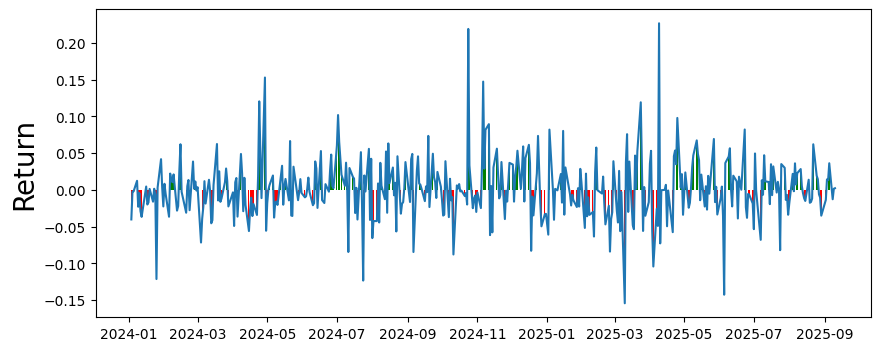

In [7]:
plt.figure(figsize=(10,4))
plt.plot(returns)
bars = plt.bar(returns.index, returns.values, color=['green' if x >= 0 else 'red' for x in returns.values])
plt.ylabel('Return', fontsize=20)

In [8]:
perform_adf_test(returns)

ADF Statistic: -20.523030
p-value: 0.000000
✅ The series is likely stationary.


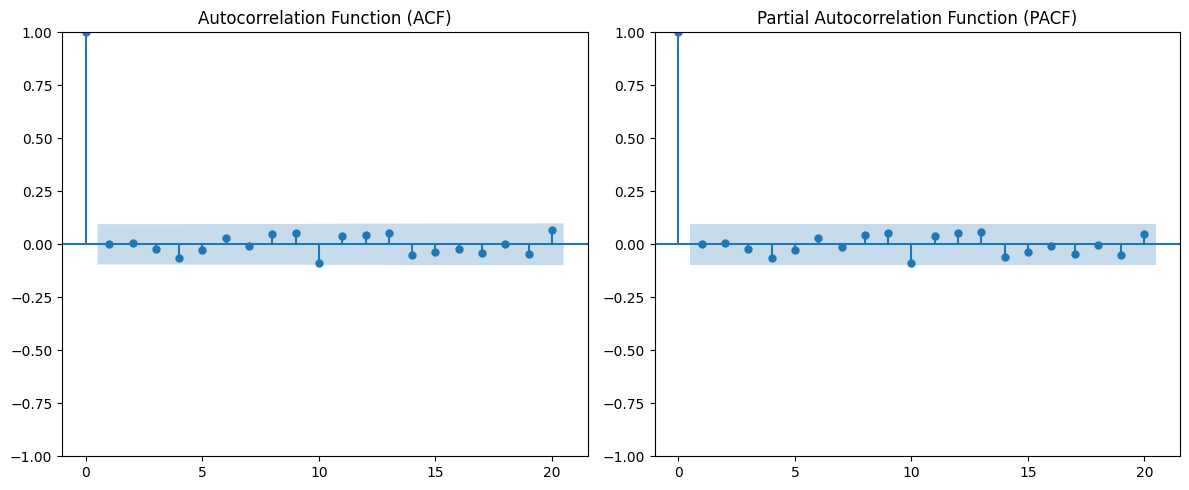

In [9]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot ACF on the first subplot
plot_acf(returns, lags=20, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# Plot PACF on the second subplot
plot_pacf(returns, lags=20, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

# Training Set

In [10]:
print(f"Total dataset length: {returns.shape[0]}")

Total dataset length: 423


In [11]:
start_index = returns.shape[0] - 30
# start_index  = 160

training_set =returns.iloc[:start_index]
print(f"Training set length: {training_set.shape[0]}")

Training set length: 393


Text(0, 0.5, 'Return')

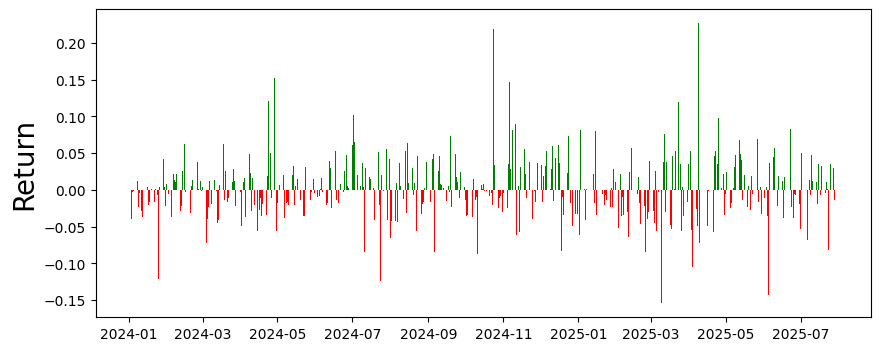

In [12]:
plt.figure(figsize=(10,4))
# plt.plot(training_set)
bars = plt.bar(training_set.index, training_set.values, color=['green' if x >= 0 else 'red' for x in training_set.values])
plt.ylabel('Return', fontsize=20)

In [13]:
perform_adf_test(training_set)

ADF Statistic: -19.865217
p-value: 0.000000
✅ The series is likely stationary.


## Based on PACF, we should start with a AR() process

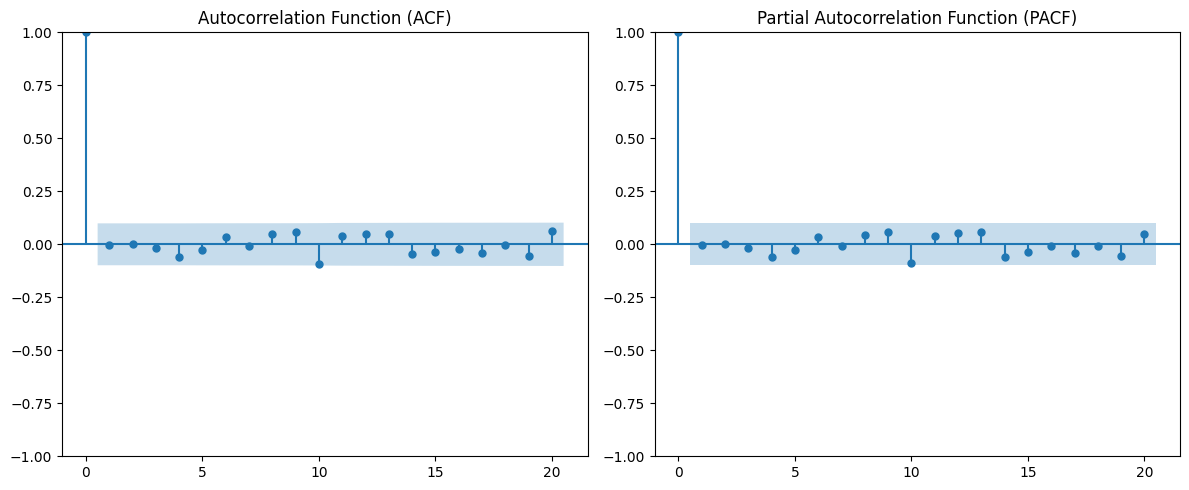

In [14]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot ACF on the first subplot
plot_acf(training_set, lags=20, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# Plot PACF on the second subplot
plot_pacf(training_set, lags=20, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

In [15]:
from time import time

model = ARIMA(training_set, order=(10,0,0))
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

print(model_fit.summary())

Model Fitting Time: 0.3297429084777832
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  393
Model:                ARIMA(10, 0, 0)   Log Likelihood                 686.234
Date:                Fri, 12 Sep 2025   AIC                          -1348.469
Time:                        21:09:31   BIC                          -1300.783
Sample:                             0   HQIC                         -1329.571
                                - 393                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.002      0.708      0.479      -0.003       0.006
ar.L1         -0.0031      0.050     -0.062      0.950      -0.101       0.095
ar.L2        

## Based on ACF, we should start with a MA() process

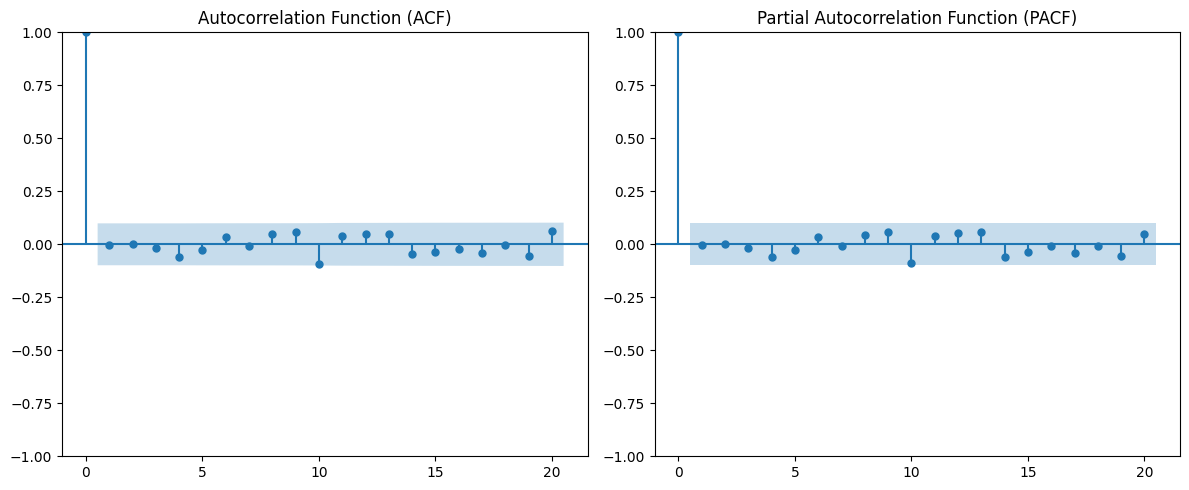

In [16]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot ACF on the first subplot
plot_acf(training_set, lags=20, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# Plot PACF on the second subplot
plot_pacf(training_set, lags=20, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

In [17]:
from time import time

model = ARIMA(training_set, order=(0,0,9))
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

print(model_fit.summary())

Model Fitting Time: 0.22129392623901367
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  393
Model:                 ARIMA(0, 0, 9)   Log Likelihood                 685.140
Date:                Fri, 12 Sep 2025   AIC                          -1348.280
Time:                        21:09:32   BIC                          -1304.568
Sample:                             0   HQIC                         -1330.958
                                - 393                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.003      0.592      0.554      -0.003       0.006
ma.L1          0.0036      0.050      0.071      0.943      -0.094       0.101
ma.L2       

## Based on PACF => AR, ACF => MA() 

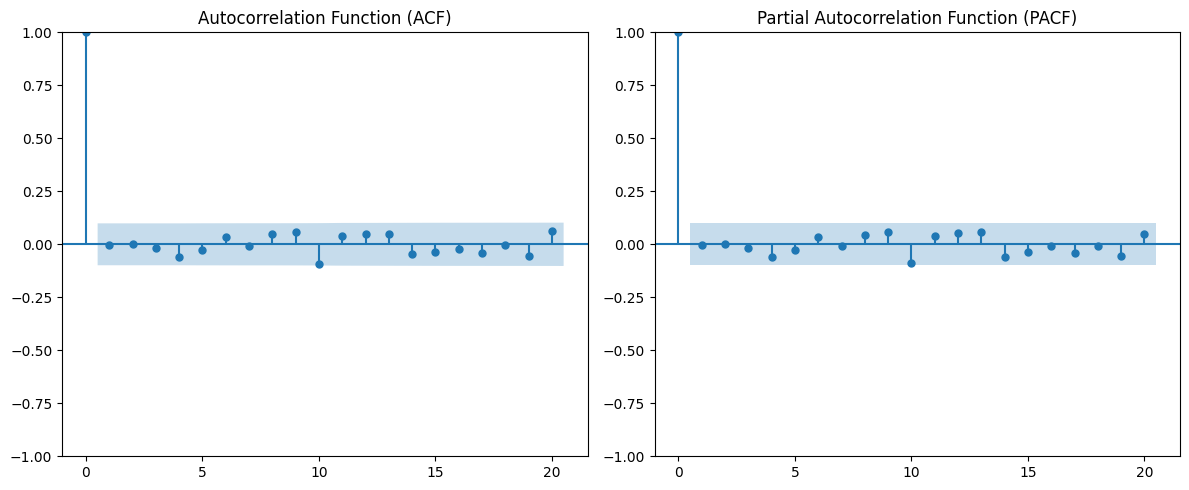

In [18]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot ACF on the first subplot
plot_acf(training_set, lags=20, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# Plot PACF on the second subplot
plot_pacf(training_set, lags=20, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

In [19]:
from time import time

model = ARIMA(training_set, order=(4,0,4))
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

print(model_fit.summary())

Model Fitting Time: 0.2168898582458496
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  393
Model:                 ARIMA(4, 0, 4)   Log Likelihood                 683.532
Date:                Fri, 12 Sep 2025   AIC                          -1347.065
Time:                        21:09:32   BIC                          -1307.326
Sample:                             0   HQIC                         -1331.317
                                - 393                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.695      0.487      -0.003       0.006
ar.L1          0.3959      0.524      0.756      0.449      -0.630       1.422
ar.L2        

In [20]:
# Predict the next value after the training set
predictions = model_fit.predict(start=start_index, end=start_index)
print(predictions)
print(f"Actural at {start_index} : {returns.iloc[start_index]}")

393    0.00262
dtype: float64
Actural at 393 : -0.006724793213012448


/Users/alanwong/miniconda3/envs/crypto/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [21]:
forecasts = model_fit.forecast()
print(forecasts)

393    0.00262
dtype: float64


# Baseline Model : Random Buying 

100%|██████████| 30/30 [00:00<00:00, 19645.45it/s]

Bought at $308.2699890136719
Sold at $302.6300048828125
Actual Return: -0.0183
Bought at $302.6300048828125
Sold at $309.260009765625
Actual Return: 0.0219
Bought at $308.7200012207031
Sold at $319.9100036621094
Actual Return: 0.0362
Bought at $335.5799865722656
Sold at $330.55999755859375
Actual Return: -0.015
Bought at $335.1600036621094
Sold at $329.30999755859375
Actual Return: -0.0175
Bought at $329.30999755859375
Sold at $323.8999938964844
Actual Return: -0.0164
Bought at $323.8999938964844
Sold at $320.1099853515625
Actual Return: -0.0117
Bought at $320.1099853515625
Sold at $340.010009765625
Actual Return: 0.0622
Bought at $340.010009765625
Sold at $346.6000061035156
Actual Return: 0.0194
Bought at $346.6000061035156
Sold at $351.6700134277344
Actual Return: 0.0146
Bought at $349.6000061035156
Sold at $345.9800109863281
Actual Return: -0.0104
Bought at $345.9800109863281
Sold at $333.8699951171875
Actual Return: -0.035
Bought at $350.8399963378906
Sold at $346.3999938964844
Act

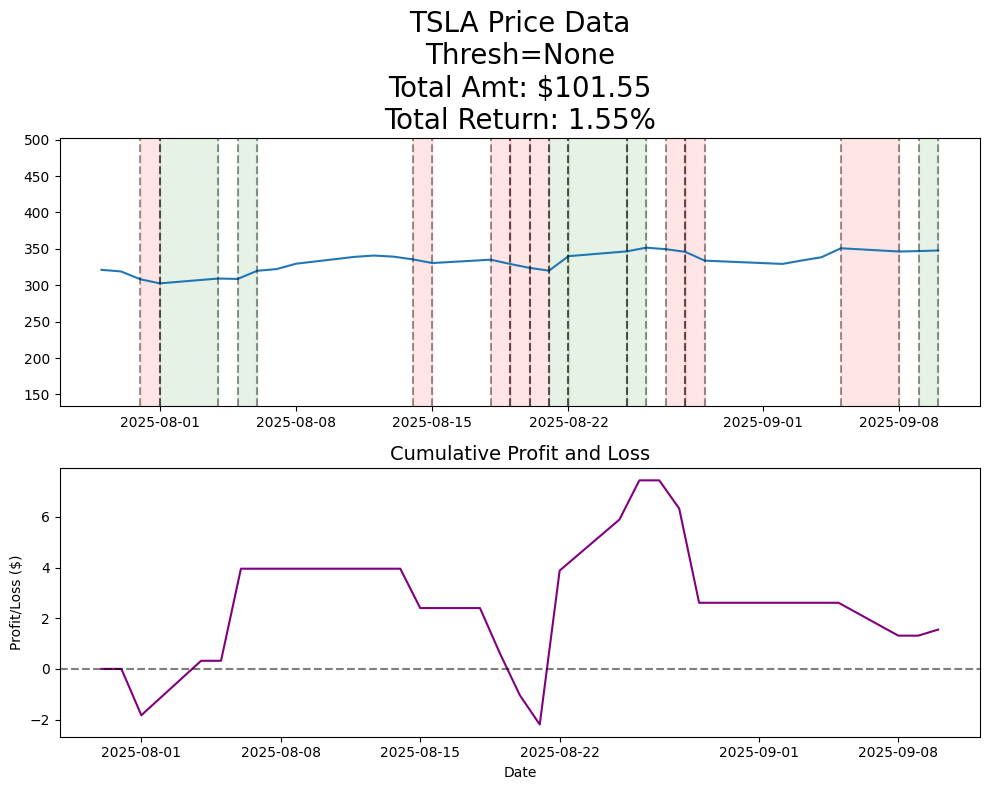

np.float64(101.55302826599927)

In [22]:
run_simulation(returns=returns, 
               prices=prices, 
               amt=100, 
               order=0.5, 
               thresh=None,
               start_idx=start_index, 
               verbose=True,
               plot=True)

In [23]:
final_amts = [run_simulation(returns=returns, 
               prices=prices, 
               amt=100, 
               order=0.5, 
               thresh=None,
               start_idx=start_index, 
               verbose=False) for _ in range(1000)]

100%|██████████| 30/30 [00:00<00:00, 45872.81it/s]


Text(0.5, 1.0, 'Avg: $104.68 \n SD: $6.15')

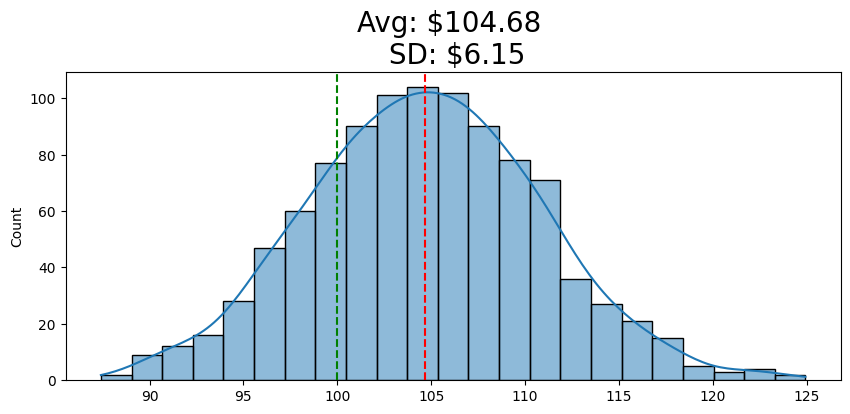

In [24]:
plt.figure(figsize=(10,4))
sns.histplot(final_amts, kde=True)
plt.axvline(np.mean(final_amts), color='r', linestyle='--')
plt.axvline(100, color='g', linestyle='--')
plt.title('Avg: $%s \n SD: $%s'%(round(np.mean(final_amts),2), round(np.std(final_amts),2)), fontsize=20)

# If Last Return was Positive, Buy

100%|██████████| 30/30 [00:00<00:00, 22692.36it/s]


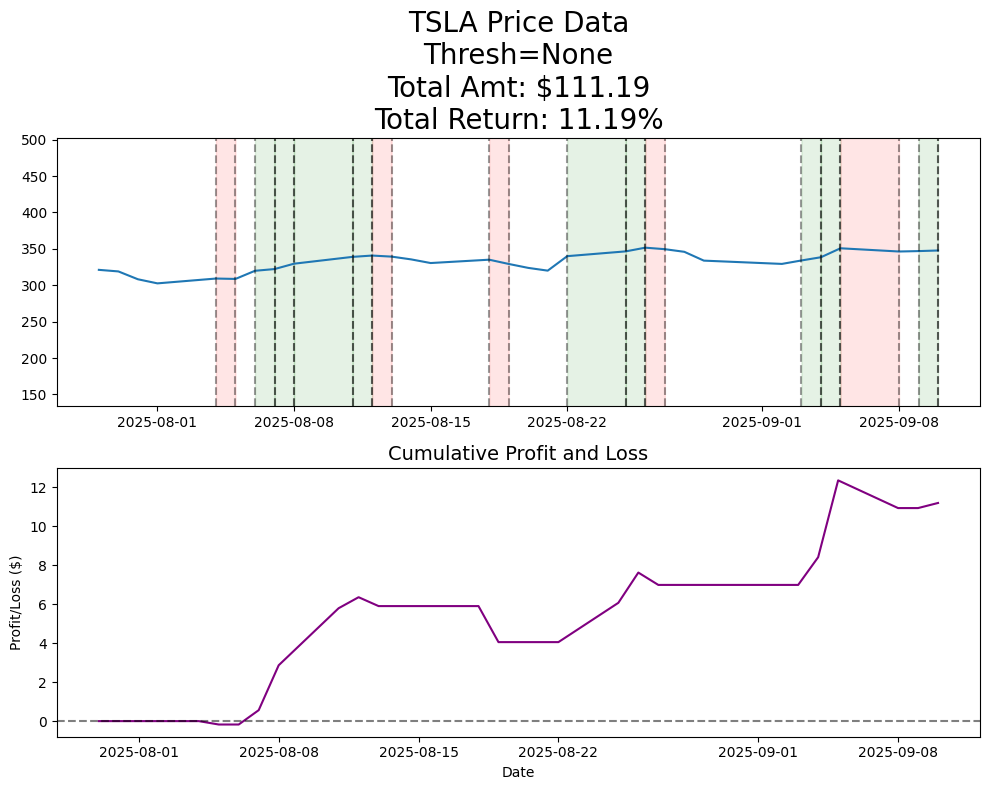

np.float64(111.19146913381321)

In [25]:
run_simulation(returns, prices, 100, 'last', None, start_index, verbose=False, plot=True)

# Try AR(4) Model

100%|██████████| 30/30 [00:05<00:00,  5.26it/s]


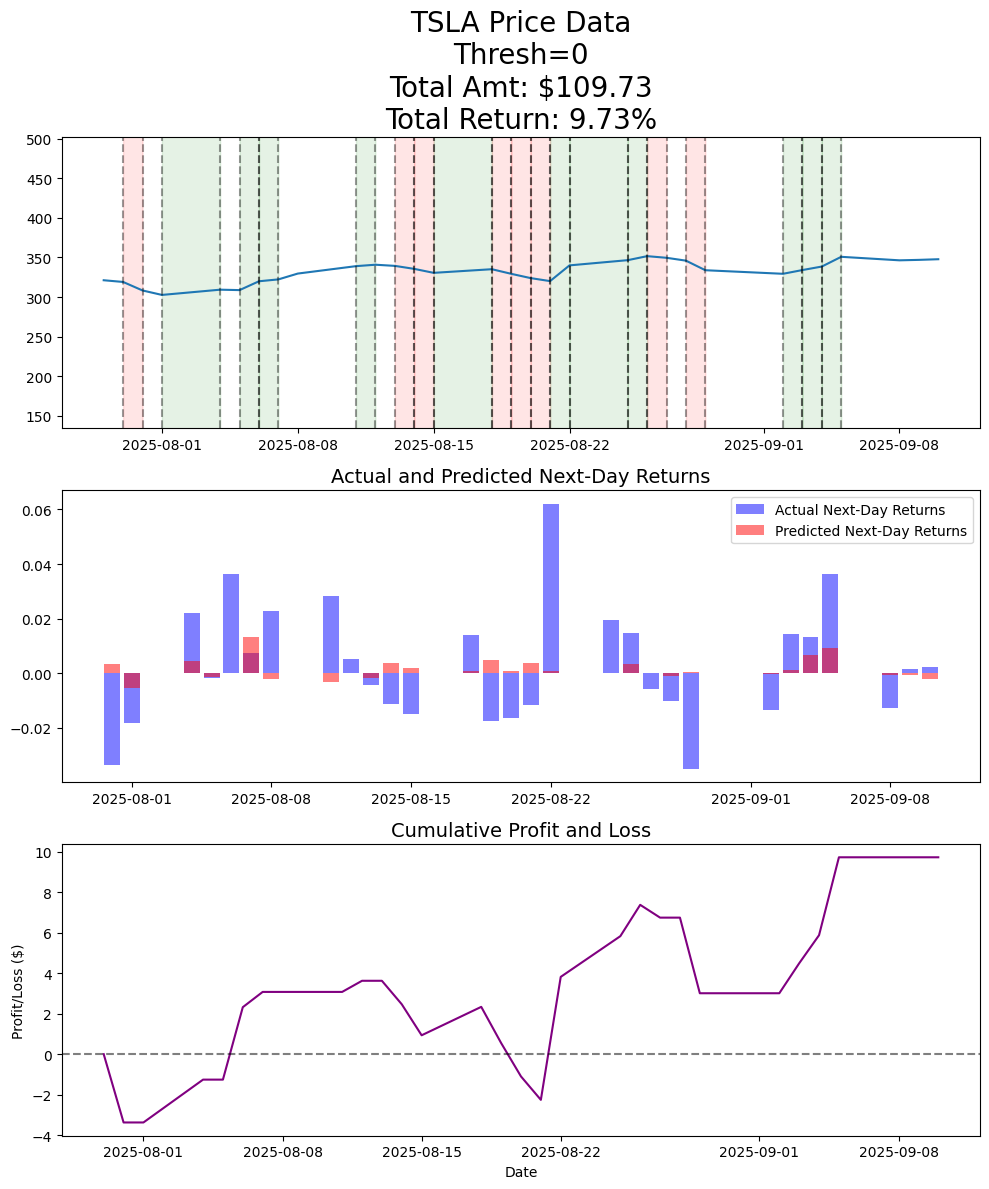

100%|██████████| 30/30 [00:05<00:00,  5.24it/s]


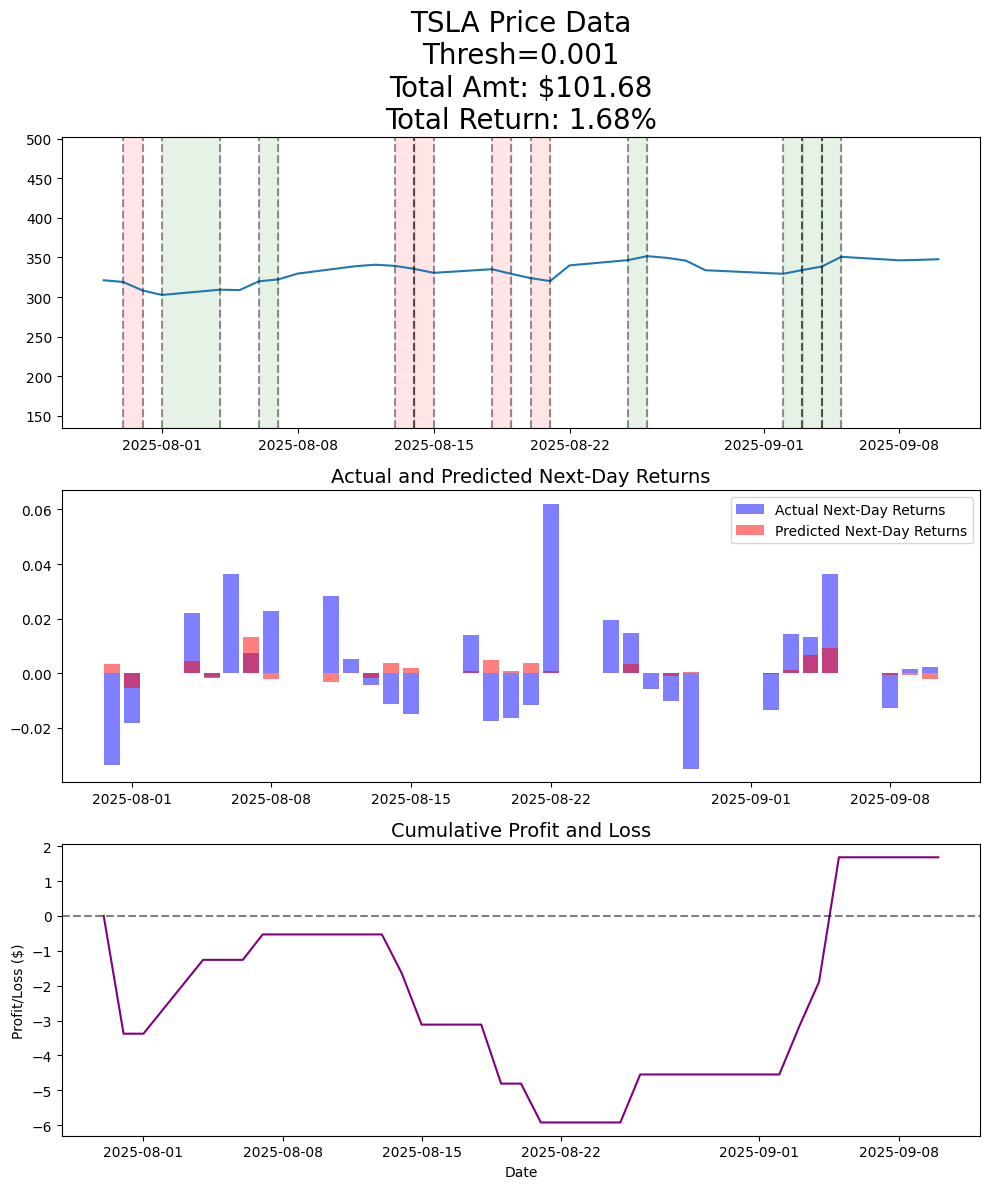

100%|██████████| 30/30 [00:05<00:00,  5.22it/s]


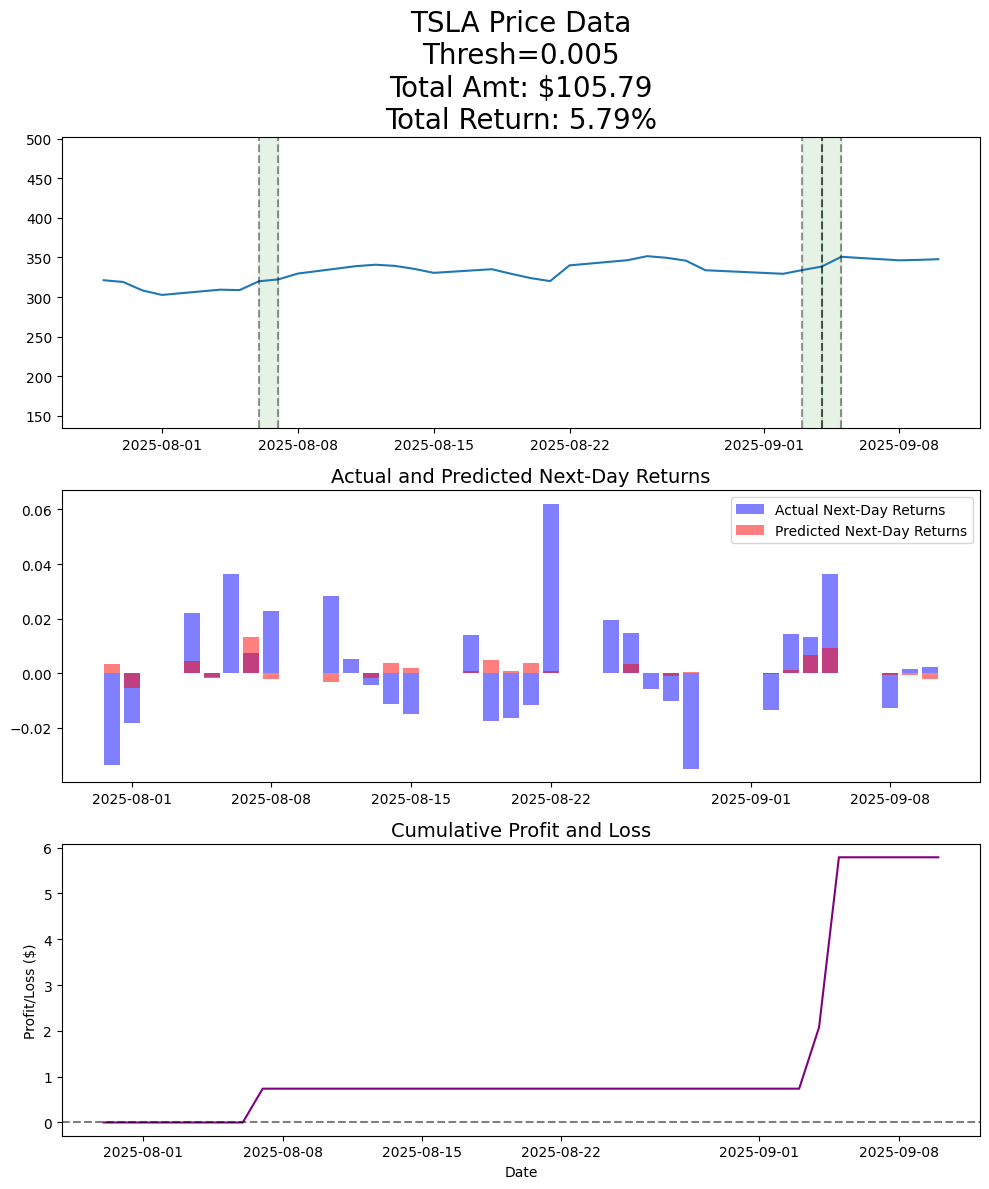

In [26]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (10,0,0), thresh, start_index, verbose=False, plot=True)

# Try MA(9) Model

100%|██████████| 30/30 [00:08<00:00,  3.58it/s]


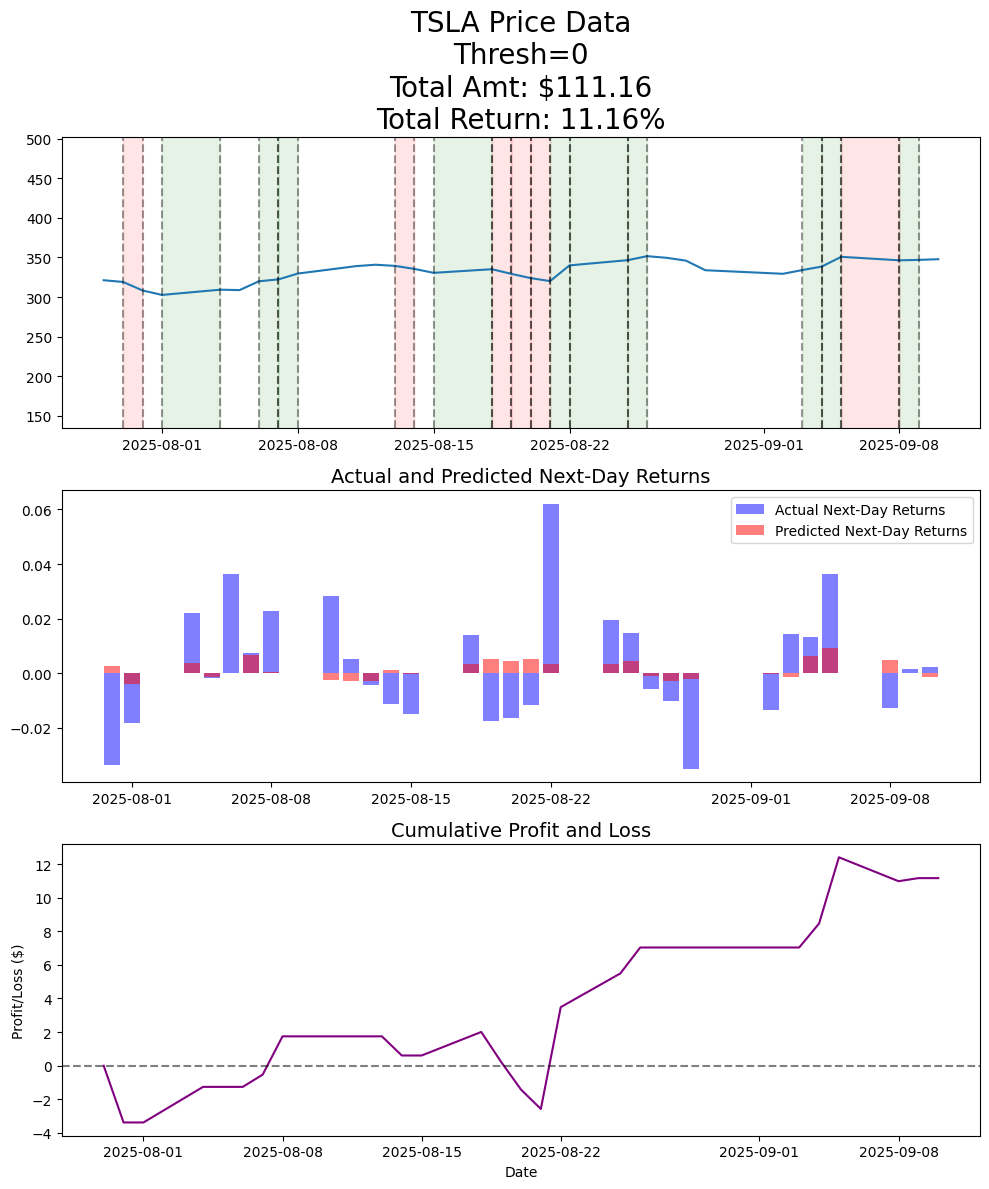

100%|██████████| 30/30 [00:08<00:00,  3.60it/s]


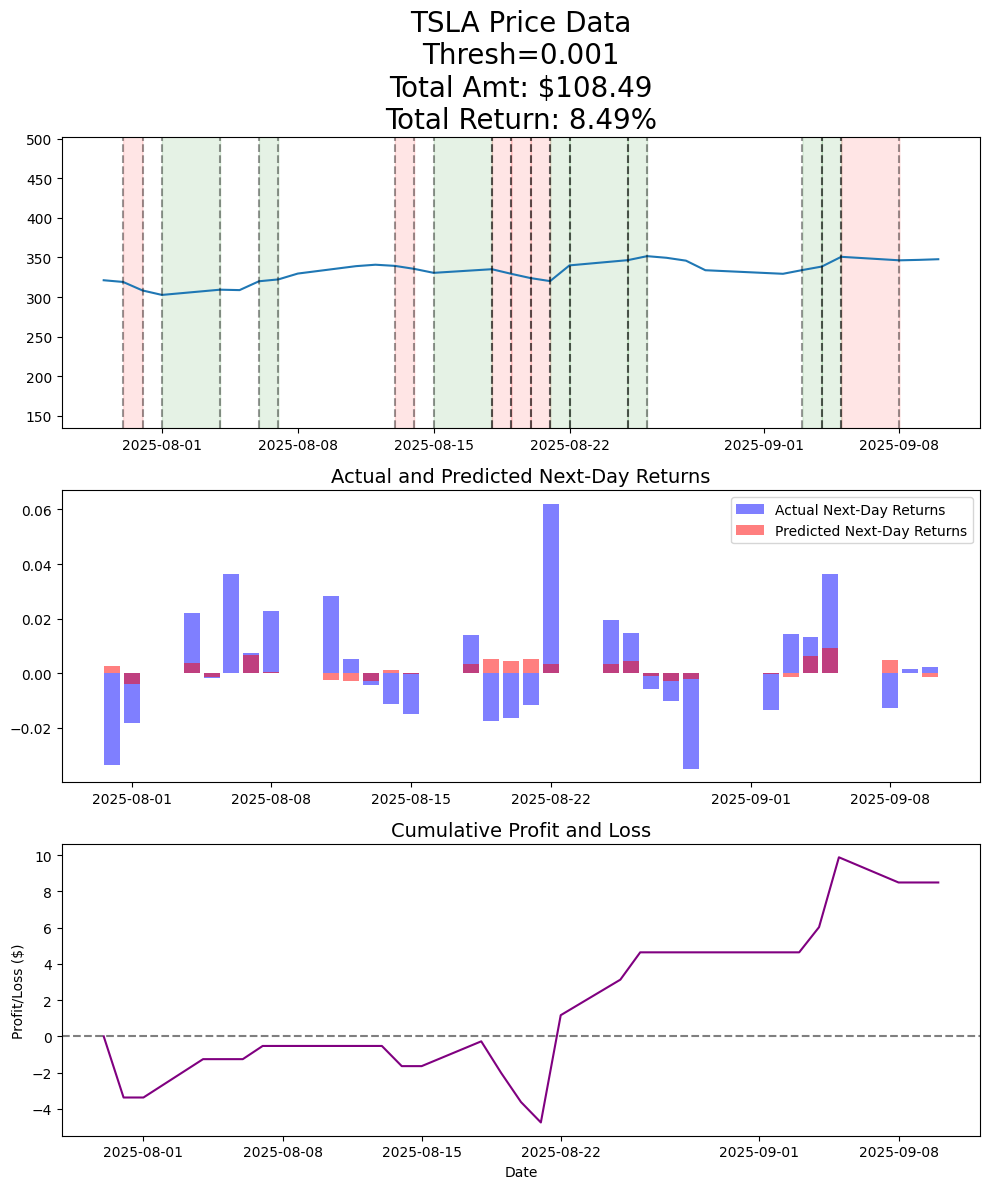

100%|██████████| 30/30 [00:08<00:00,  3.59it/s]


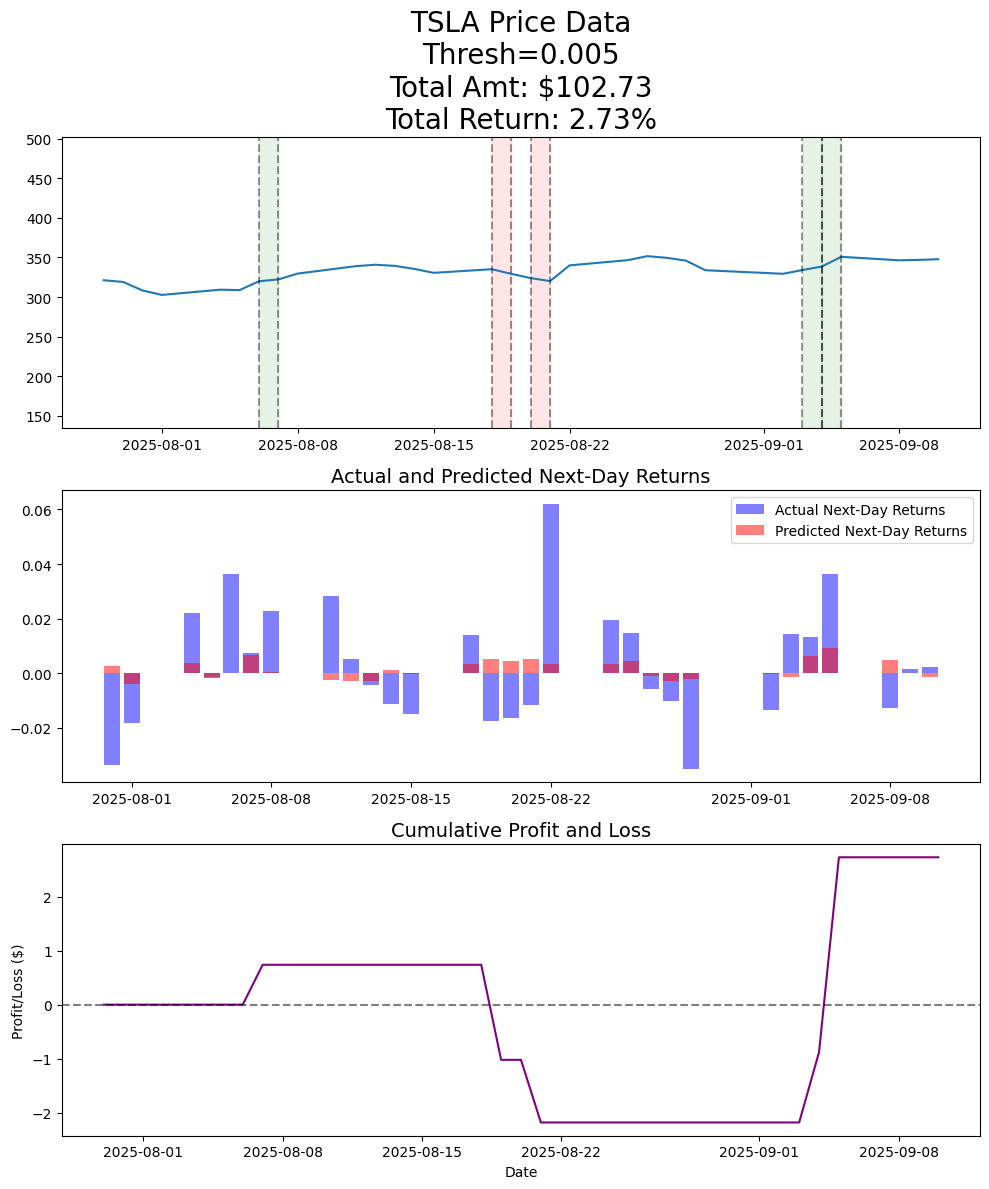

In [27]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (0,0,9), thresh, start_index,verbose=False, plot=True)

# Try ARMA(4,4) Model

  7%|▋         | 2/30 [00:00<00:06,  4.63it/s]/Users/alanwong/miniconda3/envs/crypto/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/alanwong/miniconda3/envs/crypto/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
100%|██████████| 30/30 [00:06<00:00,  4.32it/s]


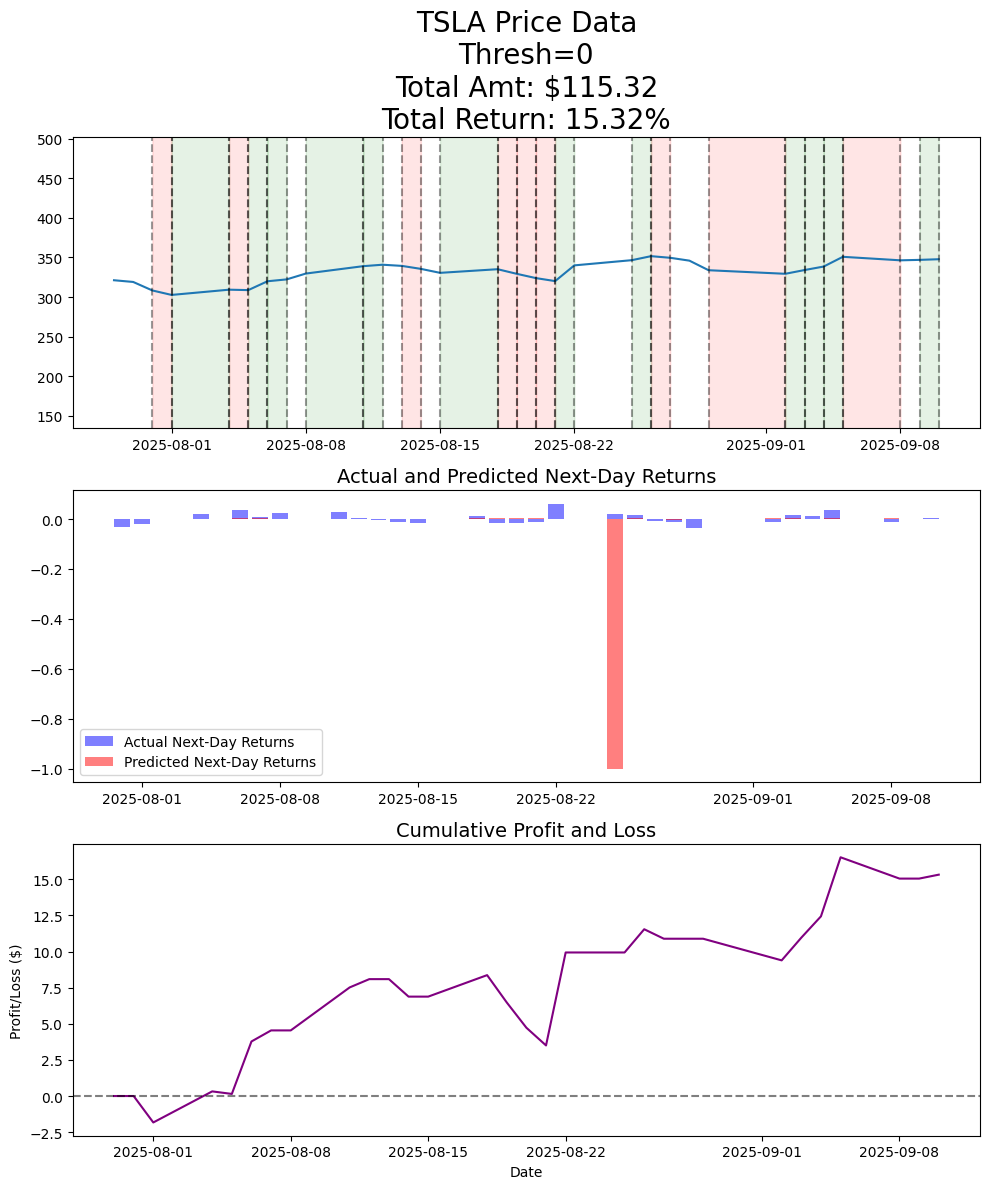

  7%|▋         | 2/30 [00:00<00:05,  4.75it/s]/Users/alanwong/miniconda3/envs/crypto/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/alanwong/miniconda3/envs/crypto/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
100%|██████████| 30/30 [00:06<00:00,  4.34it/s]


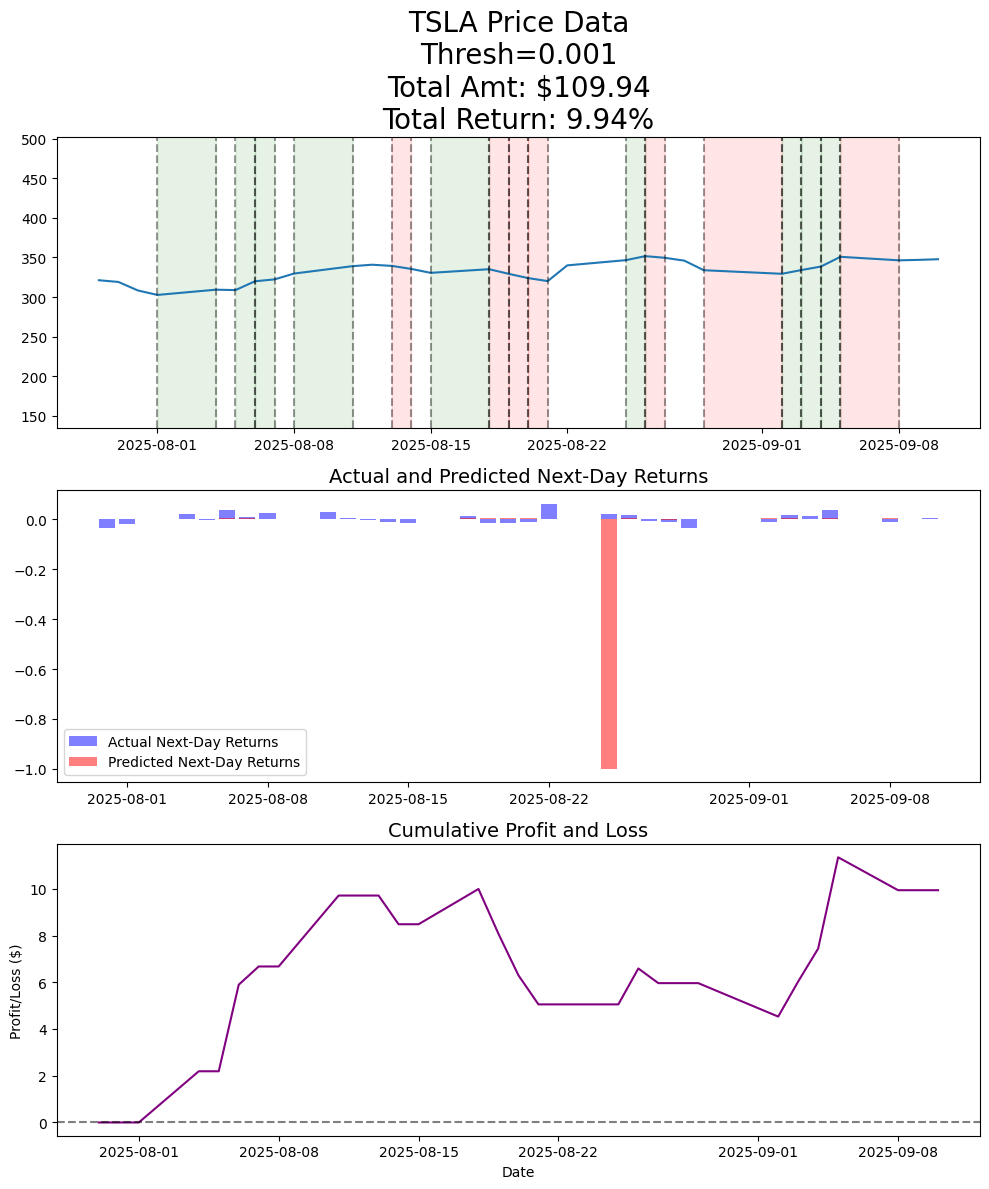

  7%|▋         | 2/30 [00:00<00:05,  4.71it/s]/Users/alanwong/miniconda3/envs/crypto/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/alanwong/miniconda3/envs/crypto/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
100%|██████████| 30/30 [00:06<00:00,  4.35it/s]


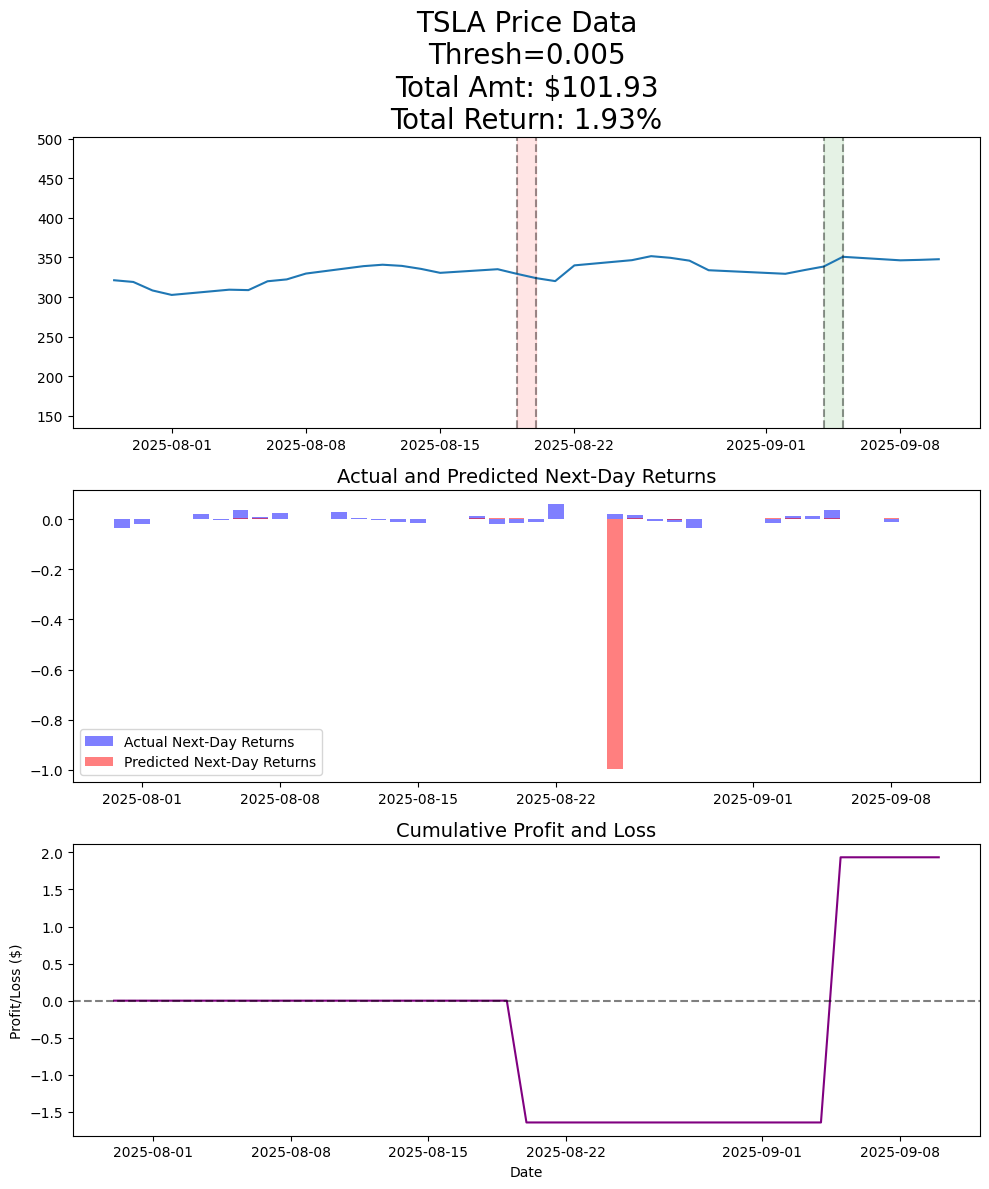

In [28]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (4,0,4), thresh, start_index, verbose=False, plot=True)